# PV power production forecasting model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# model itself
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from keras.losses import mean_absolute_percentage_error
from keras import backend as K

Using TensorFlow backend.


In [4]:
import os
os.chdir("C:\\Users\\hr\\Downloads\\Solar Forecasting\\LSTM-power-forecasting-master - Copy\\data_preparation")

In [5]:
df1 = pd.read_csv('pvdaq_data_1277_2012.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])
df2 = pd.read_csv('pvdaq_data_1277_2013.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])
df3 = pd.read_csv('pvdaq_data_1277_2014.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])

In [6]:
df = pd.concat([df1, df2, df3])
df.shape, df1.shape, df2.shape, df3.shape

((105231, 16), (35140, 16), (35044, 16), (35047, 16))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105231 entries, 2012-01-01 00:00:00 to 2014-12-31 23:45:00
Data columns (total 16 columns):
SiteID                 105231 non-null int64
ac_current             105192 non-null float64
ac_power               105192 non-null float64
ac_voltage             105192 non-null float64
ambient_temp           101525 non-null float64
dc_current             105192 non-null float64
dc_power               105192 non-null float64
dc_voltage             105192 non-null float64
inverter_error_code    105231 non-null int64
inverter_temp          105192 non-null float64
module_temp            101525 non-null float64
poa_irradiance         101525 non-null float64
power_factor           105192 non-null float64
relative_humidity      101525 non-null float64
wind_direction         101525 non-null float64
wind_speed             101525 non-null float64
dtypes: float64(14), int64(2)
memory usage: 13.6 MB


C:\Users\hr\anaconda_new\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


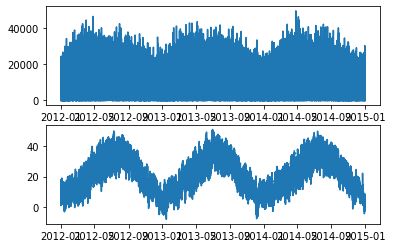

In [8]:
plt.subplot(211)
plt.plot(df.index, df['dc_power'])
plt.subplot(212)
plt.plot(df.index, df['ambient_temp'])

In [9]:
df.isnull().sum()

SiteID                    0
ac_current               39
ac_power                 39
ac_voltage               39
ambient_temp           3706
dc_current               39
dc_power                 39
dc_voltage               39
inverter_error_code       0
inverter_temp            39
module_temp            3706
poa_irradiance         3706
power_factor             39
relative_humidity      3706
wind_direction         3706
wind_speed             3706
dtype: int64

In [10]:
df.index[df.isnull().any(axis=1)].year.value_counts()

2014    3346
2013     362
2012      19
Name: Date-Time, dtype: int64

In [11]:
df_filled = pd.DataFrame()
for col in df.columns:  
  df_filled[col] = df[col].interpolate(method='slinear')

In [12]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105231 entries, 2012-01-01 00:00:00 to 2014-12-31 23:45:00
Data columns (total 16 columns):
SiteID                 105231 non-null int64
ac_current             105231 non-null float64
ac_power               105231 non-null float64
ac_voltage             105231 non-null float64
ambient_temp           105231 non-null float64
dc_current             105231 non-null float64
dc_power               105231 non-null float64
dc_voltage             105231 non-null float64
inverter_error_code    105231 non-null int64
inverter_temp          105231 non-null float64
module_temp            105231 non-null float64
poa_irradiance         105231 non-null float64
power_factor           105231 non-null float64
relative_humidity      105231 non-null float64
wind_direction         105231 non-null float64
wind_speed             105231 non-null float64
dtypes: float64(14), int64(2)
memory usage: 13.6 MB


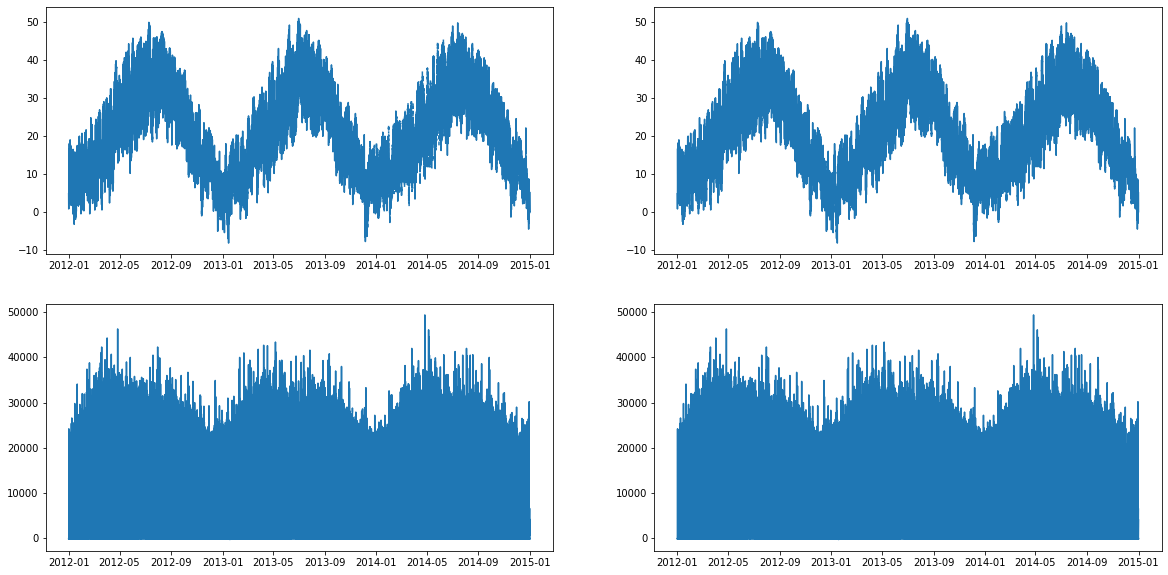

In [13]:
#print(df_filled.isnull().sum())
plt.subplots(figsize=(20, 10))
plt.subplot(221)
plt.plot(df.index, df['ambient_temp'])
plt.subplot(222)
plt.plot(df_filled.index, df_filled['ambient_temp'])
plt.subplot(223)
plt.plot(df.index, df['dc_power'])
plt.subplot(224)
plt.plot(df_filled.index, df_filled['dc_power'])

It would be better to resample our data from 15 minutes time step to hourly data.


In [14]:
df_resampled = df_filled.resample('1H').mean()

In [15]:
df_resampled.head(4)

,SiteID,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
Date-Time,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,1277.0,0.0,-150.0,285.50,4.437502,-1.0,-100.0,0.25,0.0,16.5,0.208335,0.0,0.0,44.62800,306.70350,0.565841
2012-01-01 01:00:00,1277.0,0.0,-125.0,285.50,3.668335,-1.0,-100.0,0.00,0.0,15.5,-1.299999,0.0,0.0,47.33125,306.72025,0.577687
2012-01-01 02:00:00,1277.0,0.0,-150.0,285.75,3.080418,-1.0,-100.0,0.25,0.0,14.5,-2.466665,0.0,0.0,46.12350,306.75950,0.518231
2012-01-01 03:00:00,1277.0,0.0,-175.0,284.50,2.910418,-1.0,-100.0,0.00,0.0,14.0,-2.327777,0.0,0.0,38.91425,307.95750,0.447711


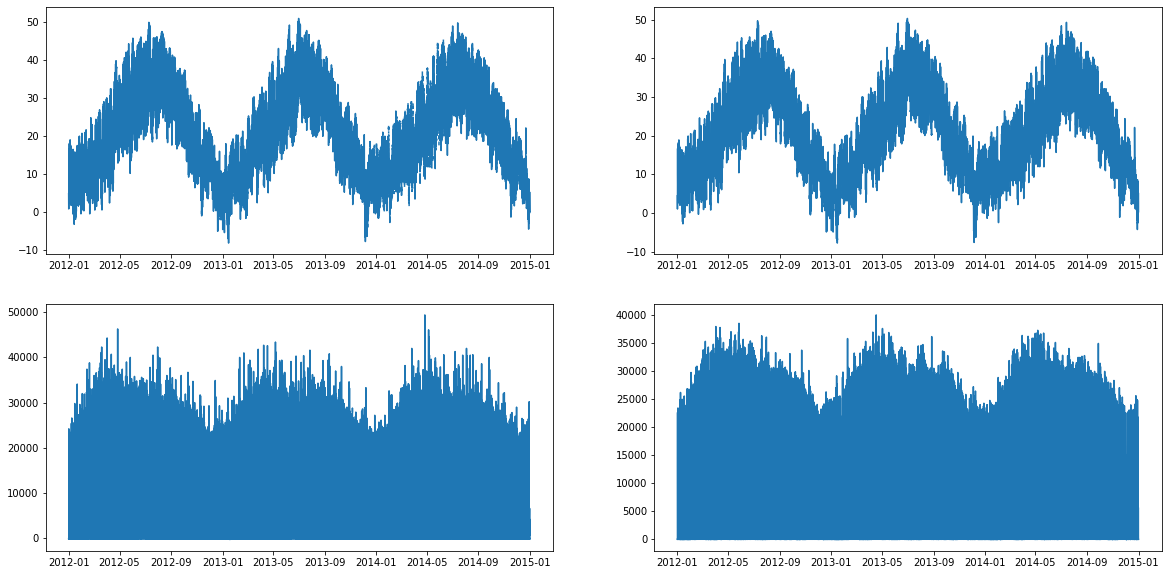

In [16]:
plt.subplots(figsize=(20, 10))
plt.subplot(221)
plt.plot(df.index, df['ambient_temp'])
plt.subplot(222)
plt.plot(df_resampled.index, df_resampled['ambient_temp'])
plt.subplot(223)
plt.plot(df.index, df['dc_power'])
plt.subplot(224)
plt.plot(df_resampled.index, df_resampled['dc_power'])

In [0]:
df_resampled.to_csv('pvdaq_2012_2014_hourly.csv')